<font size="5"><center>Tópicos selectos de ciencia de datos<center><font>
<font size="4"><center>Tarea 3<center>
<center>Iván Vega Gutiérrez<center>

## Ejercicio 1

1. Dados los siguientes parámetros para algún eje (canal) de un tensor:

- $i$: tamaño de los datos de entrada (cuadradas: $i_1=i_2=i$) 
- $k$: tamaño de un kernel de convolución cuadrado
- $s$: tamaño de stride (igual en ambas direcciones)
- $p$: zero padding (igual en ambas direcciones)

obtén una expresión para calcular:

    a) el tamaño de salida del mapeo luego de realizar una convolución.
    b) el tamaño de salida del proceso de pooling

**Solución**

Sea $i$ el tamaño de la entrada, $k$ el tamaño del kernel, $s$ el tamaño del stride. 

Dado que $k<i$ al aplicar el filtro en el primer paso tenemos  $i-k$ espacios disponibles para la aplicación del filtro, por lo tanto la salida del mapeo será de $i-k+1$ por $i-k+1$, esto tomando en cuenta que el stride es 1.

Ahora, considerando el zero padding, el tamaño de la entrada incrementa $2*p$, por lo que la entrada sería de tamaño $i + 2*p$, por lo tanto el tamaño de la salida aplicando el kernel sería de $i+2*p - k +1$, nuevamente tomando en cuenta que el stride es 1.

Ahora supongamos que el tamaño del stride es $s$. Al considerar este tamaño de stride, podemos observar que si $s=2$, el número de la salida se reduce a la mitad, si $s=3$ el tamaño de la salida debería dividirse entre 3, de manera general el tamaño del stride reduce la salida por $\frac{1}{s}$. Por lo tanto el tamaño de la salida sería $$\frac{i+2*p-k}{s} +1 $$



De manera análoga se obtiene el tamaño de salida cuando se hace el proceso de pooling, ya que el tamaño de salida del mapeo sería igual que al realizar una convolución.

# Ejercicio 2

2. Considera de nuevo el corpus `hispablogs.zip` que usaste en la tarea 2. 
    
    a) Implementa un clasificador basado en redes convolucionales. Especifica TODOS los parámetros que usaste en tus métodos (número de capas y unidades ocultas, longitud de secuencia, padding, regularización, etc). Usa una capa de embeddings con y sin transfer learning usando pesos pre-entrenados para español, verifica si los resultados son diferentes y elige cuál embedding prefieres y porqué. Para transfer learning, puedes usar `word2vec`, `gloVe` o `fastText`. Compara el resultado con el baseline que implementaste anteriormente. Haz un breve reporte comparando los resultados, elige el mejor método y explica porqué. 
    
    b) **OPCIONAL (puntos extra)**. Obtén la representación de las capas convolucionales e intermedias de tu modelo, incluyendo (principalmente) la capa final. Visualiza las representaciones en baja dimensión ¿Encuentras patrones interesantes? 
    
    c) **Competencia opcional**. Se abrirá una competencia por el mejor resultado en éste conjunto de datos. El resultado ganador obtendrá un premio en puntos y en especie (que se dará al final del curso). Para participar en ella, se deberá crear una función 
    
    `predict_data(model, data_test)`
    
    donde
    - `model` es el modelo con el cual competirás
    - `data_test` es el conjunto de datos con los cuáles se evaluará tu modelo. Este será un data frame de Pandas con dos columnas, la primera contendrá el texto y la segunda la categoría.
    
    En ésta función, la inferencia deberá hacerse con CPU, se deberá cargar los parámetros de tu modelo en un archivo local (por supuesto, deberás proporcionar el archivo), y deberá regresar una lista con las predicciones del `data_test`.

## Dataset hipablogs

Sol a) Cargamos el corpus hispablogs

In [21]:
import os
import re

def get_texts_from_dir(cat_dir):
    texts = []
    data_dir = cat_dir
    category_index = {}
    categories = []
    for category_name in sorted(os.listdir(data_dir)):
        category_id = len(category_index)
        category_index[category_name] = category_id
        category_path = os.path.join(data_dir, category_name)
        for f_name in sorted(os.listdir(category_path)):
            f_path = os.path.join(category_path, f_name)
            f = open(f_path, "r", encoding="utf8")
            texts += [f.read()]                
            f.close()
            categories += [category_id]
    print("%d files loaded from %s" % (len(texts), cat_dir))
    return texts, categories, category_index

# Load the RAW text and Category labels
tr_txt, tr_y, tr_y_ind = get_texts_from_dir("hispablogs/train")
te_txt, te_y, te_y_ind = get_texts_from_dir("hispablogs/test")

2250 files loaded from hispablogs/train
1000 files loaded from hispablogs/test


## Carga de embeddings

Cargamos los embeddings word2vec y los guardamos en un diccionario, donde la clave será la palabra y el contenido de la clave tendrá los pesos de las palabras.

In [22]:
import numpy as np
import io
embeddings_index = {}
f = open(os.path.join('SBW-vectors-300-min5.txt'))
i = 0
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
    i+=1
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 1000654 word vectors.


## Tokenización

Hacemos la tokenizacion de nuestro corpus, considerando tanto los datos de entrenamiento como los de prueba.

In [40]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
maxlen = 1000
max_words = 100000
training_samples = 2250
# Realizamos la tokenización de nuestro corpus
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(tr_txt+te_txt)
sequences = tokenizer.texts_to_sequences(tr_txt+te_txt)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 279735 unique tokens.


## Pad sequence

Utilizamos pad sequence para mantener la misma dimension y asi poder crear los datos de entrenamiento y prueba.

In [41]:
data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(tr_y + te_y)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_test = data[training_samples: ]
y_test = labels[training_samples: ]

Shape of data tensor: (3250, 1000)
Shape of label tensor: (3250,)


A continuacion creamos la matriz de embeddings 

In [42]:
# La dimension de los embeddings preentrenados es de 300
embedding_dim = 300
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        # Si la palabra esta en el corpus la agregamos a la matriz de embeddings
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

## Arquitectura del modelo

El modelo que se utilizará contiene 128 filtros con un tamaño de kernel de 25, y una capa de 30 unidades ocultas con función de activación relu. Se utiliza el optimizador Adam y el tamaño del batch es de 32 con 12 epocas.

In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
max_features = 100000
max_len = 1000
model = Sequential()
model.add(layers.Embedding(max_features, 300, input_length=max_len))
model.add(layers.Conv1D(256, 25, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(128))
model.add(layers.Dense(5, activation = 'softmax'))

## Entrenamiento del modelo sin transfer learning

Epoch 1/12
57/57 [==============================] - 66s 1s/step - loss: 1.6322 - acc: 0.2027 - val_loss: 1.5723 - val_acc: 0.2911
Epoch 2/12
57/57 [==============================] - 65s 1s/step - loss: 0.9359 - acc: 0.8966 - val_loss: 1.3874 - val_acc: 0.4444
Epoch 3/12
57/57 [==============================] - 63s 1s/step - loss: 0.0197 - acc: 1.0000 - val_loss: 1.3242 - val_acc: 0.5133
Epoch 4/12
57/57 [==============================] - 64s 1s/step - loss: 0.0034 - acc: 1.0000 - val_loss: 1.3066 - val_acc: 0.5133
Epoch 5/12
57/57 [==============================] - 62s 1s/step - loss: 0.0018 - acc: 1.0000 - val_loss: 1.2989 - val_acc: 0.5222
Epoch 6/12
57/57 [==============================] - 61s 1s/step - loss: 0.0013 - acc: 1.0000 - val_loss: 1.2952 - val_acc: 0.5133
Epoch 7/12
57/57 [==============================] - 61s 1s/step - loss: 9.7285e-04 - acc: 1.0000 - val_loss: 1.2916 - val_acc: 0.5267
Epoch 8/12
57/57 [==============================] - 61s 1s/step - loss: 7.5934e-04 - a

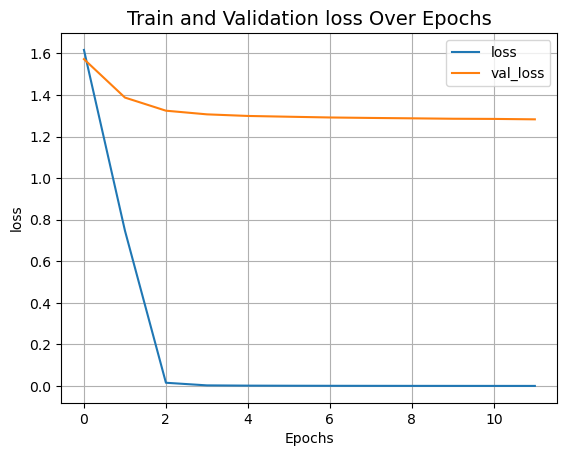

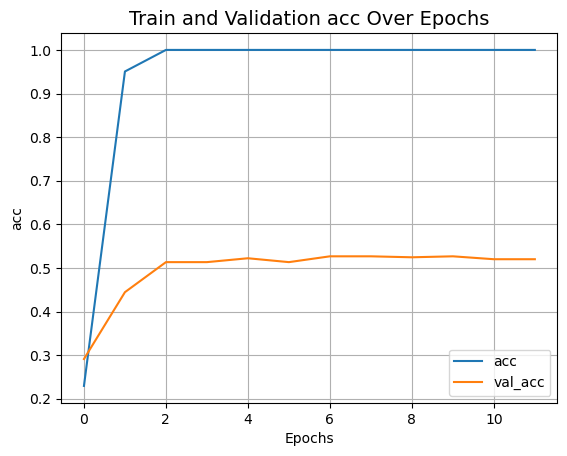

In [63]:
import matplotlib.pyplot as plt
model.compile(optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['acc'])
history = model.fit(x_train, y_train,
epochs = 12,
batch_size = 32,
validation_split=0.2)

def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()
    
plot_result('loss')
plot_result('acc')

In [64]:
model.evaluate(x_test,y_test)

32/32 [==============================] - 9s 271ms/step - loss: 1.2991 - acc: 0.4850


[1.2991302013397217, 0.48500001430511475]

## Entrenamiento del modelo con transfer learning

En este apartado utilizamos el modelo anterior pero ahora utilizando transfer learning.

In [65]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
max_features = 100000
max_len = 1000
model_emb = Sequential()
model_emb.add(layers.Embedding(max_features, 300, input_length=max_len))
model_emb.add(layers.Conv1D(256, 25, activation='relu'))
model_emb.add(layers.GlobalMaxPooling1D())
model_emb.add(layers.Dense(128))
model_emb.add(layers.Dense(5, activation = 'softmax'))

Ahora, entrenamos el modelo pero tomando en cuenta la matriz de pesos de los embeddings.

In [66]:
model_emb.layers[0].set_weights([embedding_matrix])
model_emb.layers[0].trainable = False

Entrenamos el modelo con los mismos parametros utilizados en el modelo sin transfer learning.

Epoch 1/12
57/57 [==============================] - 46s 787ms/step - loss: 1.7087 - acc: 0.2452 - val_loss: 1.5725 - val_acc: 0.2933
Epoch 2/12
57/57 [==============================] - 44s 776ms/step - loss: 1.4860 - acc: 0.3679 - val_loss: 1.5104 - val_acc: 0.3556
Epoch 3/12
57/57 [==============================] - 45s 783ms/step - loss: 1.2054 - acc: 0.5873 - val_loss: 1.7532 - val_acc: 0.3533
Epoch 4/12
57/57 [==============================] - 46s 808ms/step - loss: 0.6659 - acc: 0.7967 - val_loss: 1.5001 - val_acc: 0.4422
Epoch 5/12
57/57 [==============================] - 45s 794ms/step - loss: 0.1233 - acc: 0.9979 - val_loss: 1.7470 - val_acc: 0.3422
Epoch 6/12
57/57 [==============================] - 46s 804ms/step - loss: 0.0242 - acc: 1.0000 - val_loss: 1.4696 - val_acc: 0.4289
Epoch 7/12
57/57 [==============================] - 45s 794ms/step - loss: 0.0090 - acc: 1.0000 - val_loss: 1.4566 - val_acc: 0.4356
Epoch 8/12
57/57 [==============================] - 43s 760ms/step - 

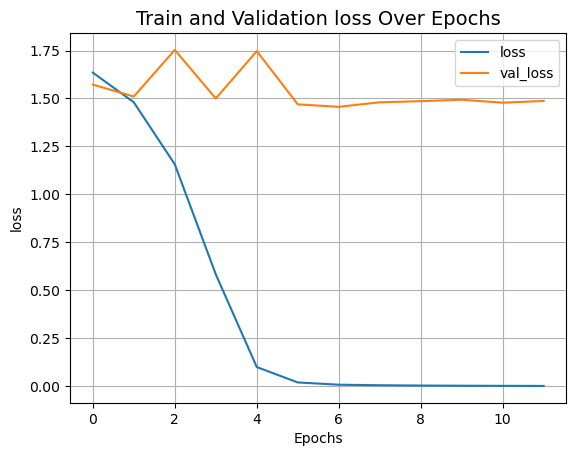

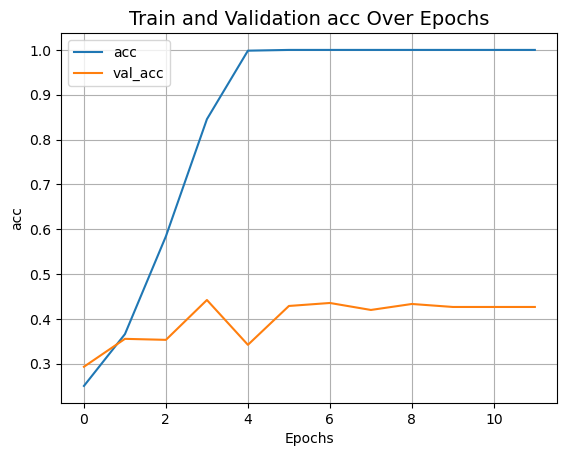

In [67]:
model_emb.compile(optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['acc'])
history = model_emb.fit(x_train, y_train,
epochs = 12,
batch_size = 32,
validation_split=0.2)
plot_result('loss')
plot_result('acc')

In [68]:
model_emb.evaluate(x_test,y_test)

32/32 [==============================] - 9s 265ms/step - loss: 1.4512 - acc: 0.4570


[1.451206922531128, 0.4569999873638153]

A modo de conclusión podemos decir que al incorporar los embeddings preentrenados del modelo word2vec no existe una mejora en la precisión del modelo.

# Ejercicio 3

3. Considera los datos del `Amazon Reviews Corpus`, que contiene reseñas de diversos productos, junto con su evaluación. Usa los datos en español, el cual puedes cargarlo con el siguiente código: 

Repite los incisos del ejercicio 2 pero con las siguientes consideraciones: 

- Usa solamente las reseñas de los productos `['home', 'wireless', 'toy', 'sports', 'pc', 'home_improvement', 'electronics']`. 

- Implementa dos clasificadores, uno para el tipo de producto y otro para el sentimiento. Para éste último, considera el sentimiento como: `negativo:` 1 y 2 estrellas, `positivo:` 3, 4 y 5 estrellas.

**Notas**: 
- Usa los datos `train` y `validation` para construir tu modelo, y reserva los datos `test` para evaluarlo.

- También habrá una competencia opcional, con las mismas instrucciones que el ejercicio anterior.

- Puedes aprovechar las funcionalidades de la librería `datasets`, de donde se extrajeron los datos. Información sobre la librería y los datasets puedes verlos en éste [link](https://pypi.org/project/datasets/).

In [2]:
from datasets import load_dataset, get_dataset_config_names
from IPython.display import display, HTML

dataset_name = "amazon_reviews_multi"
dataset = load_dataset(path=dataset_name, name="es")
print(dataset)

dataset.set_format("pandas")
df = dataset["train"][:]
sample = df.sample(n=8, random_state=42)
display(HTML(sample.to_html()))

Found cached dataset amazon_reviews_multi (/home/vega/.cache/huggingface/datasets/amazon_reviews_multi/es/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 200000
    })
    validation: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 5000
    })
})


,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
119737,es_0407390,product_es_0581068,reviewer_es_0240856,3,Mini usb cable de carga defectuoso por lo cual se estropearon los usb de las baterias,El drone funciona a la perfeccion,es,toy
72272,es_0543653,product_es_0928614,reviewer_es_0576116,2,El cable es muy largo y es comodo pero me duró poco tiempo porque el conector microusb se me acabó doblando,Muy Largo,es,wireless
158154,es_0723575,product_es_0453054,reviewer_es_0143292,4,Ideal para mis necesidades.,Práctico,es,home
65426,es_0051657,product_es_0422258,reviewer_es_0046219,2,"Es desigual el color, y mancha. El hilo de rompe con demasiada facilidad y yo creo que viene de menos.","Cómo en Aliexpress, pero más caro",es,home
30074,es_0500242,product_es_0617238,reviewer_es_0557698,1,Los comentarios se hacen cuando uno recibe la mercancía. antes de recibirla es imposible si llega el lunes serán 5 días de retraso,No recibido,es,watch
23677,es_0889640,product_es_0014237,reviewer_es_0537246,1,"Después de estar esperando a que me envíen el producto 1 mes, me indican que no tienen stock y me devuelven el dinero. Y digo yo....si no tienen para que narices lo ponen a la venta? Impresentables estos chinos que por ahorrarnos unos € luego pasa lo que pasa.",IMPRESENTABLES,es,pet_products
134858,es_0354744,product_es_0727645,reviewer_es_0853808,4,"Al parecer es un tratamiento a largo plazo, dos meses descansar uno, o dos y dos. La ingesta de más producto no beneficia más, el organismo lo elimina mediante la orina. Si lleva todo lo que dice, beneficioso será. Yo personalmente he notado mejoría, pero lo cierto es que también he retomado la actividad física (bici y gimnasio) que tenía abandonada hace tiempo, y eso también ayuda a encontrarse mejor. Es mi primer bote y le daré oportunidad. Repetiré. Un saludo!!!",Parece que funciona.,es,drugstore
176418,es_0656835,product_es_0925904,reviewer_es_0636546,5,se adapta a mis necesidades,bien,es,camera


In [3]:
df_train = dataset['train']
df_validation = dataset['validation']
df_test = dataset['test']

Pasamos del datasets a dataframes para la manipulación de los datos.

### Datos de entrenamiento

In [4]:
import pandas as pd
train_data = pd.DataFrame(df_train['review_body'] )
train_data['product_category'] = df_train['product_category']
train_data['stars'] = df_train['stars']
train_data

,review_body,product_category,stars
0,Nada bueno se me fue ka pantalla en menos de 8...,electronics,1
1,"Horrible, nos tuvimos que comprar otro porque ...",electronics,1
2,Te obligan a comprar dos unidades y te llega s...,drugstore,1
3,"No entro en descalificar al vendedor, solo pue...",wireless,1
4,Llega tarde y co la talla equivocada,shoes,1
...,...,...,...
199995,Mando funciona perfectamente y cumple con toda...,electronics,5
199996,"Compré la batería con cierta reticencia, pero ...",electronics,5
199997,Buena calidad. Satisfecha con la compra.,apparel,5
199998,Perfecto para el cumple de mi hijo,toy,5


### Datos de validación

In [5]:
validation_data = pd.DataFrame(df_validation['review_body'] )
validation_data['product_category'] = df_validation['product_category']
validation_data['stars'] = df_validation['stars']
validation_data

,review_body,product_category,stars
0,"Malisimo, muy grande demasiado aparatoso y mal...",wireless,1
1,No he recibido el pedido no la devolución,apparel,1
2,"Tengo que buscar otro sistema, este no funcion...",sports,1
3,Utilicé las brocas de menor diámetro y se me d...,home_improvement,1
4,No me gusta su olor a viejo y aspecto malo,beauty,1
...,...,...,...
4995,Me ha encantado la cesta. Ha llegado impecable...,home,5
4996,Desempeña su función correctamente,camera,5
4997,Me ha encantado la diadema! Las flores son tal...,toy,5
4998,"A mi me gustan mucho las fundas TPU, ya que so...",wireless,5


### Datos de entrenamiento

In [6]:
test_data = pd.DataFrame(df_test['review_body'] )
test_data['product_category'] = df_test['product_category']
test_data['stars'] = df_test['stars']
test_data

,review_body,product_category,stars
0,no me llego el articulo me lo mando por correo...,wireless,1
1,"la mensajería horrible, no compro mas",home,1
2,Estoy muy decepcionado con el vendedor ya que ...,toy,1
3,Mi valoración no es sobre el producto sino sob...,home,1
4,Pues tenía interés en este libro y probé la ve...,digital_ebook_purchase,1
...,...,...,...
4995,Para lo que cuesta es perfecto porque cumple s...,wireless,5
4996,"Material muy flexible y cómodo, acorde a la de...",wireless,5
4997,Se ve bien el grabado,home,5
4998,lo compré para mi bici pero finalmente se lo h...,sports,5


Usamos solamente las reseñas de los productos: home, wireless, toy, sports, pc, home_improvement y electronics.

In [7]:
Products = ['home', 'wireless', 'toy', 'sports', 'pc', 'home_improvement', 'electronics']
pat = r'(\b{}\b)'.format('|'.join(Products))
train_data = train_data[train_data["product_category"].str.contains(pat, case=False, na=False)].sample(frac = 1).reset_index(drop = True)
validation_data = validation_data[validation_data["product_category"].str.contains(pat, case=False, na=False)].sample(frac = 1).reset_index(drop = True)
test_data = test_data[test_data["product_category"].str.contains(pat, case=False, na=False)].sample(frac = 1).reset_index(drop = True)

/tmp/ipykernel_23905/4257280385.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  train_data = train_data[train_data["product_category"].str.contains(pat, case=False, na=False)].sample(frac = 1).reset_index(drop = True)
/tmp/ipykernel_23905/4257280385.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  validation_data = validation_data[validation_data["product_category"].str.contains(pat, case=False, na=False)].sample(frac = 1).reset_index(drop = True)
/tmp/ipykernel_23905/4257280385.py:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  test_data = test_data[test_data["product_category"].str.contains(pat, case=False, na=False)].sample(frac = 1).reset_index(drop = True)


### Generación de etiquetas para producto y sentimiento.

A continuación se hace la transormación de etiquetas de las categorías y el sentimiento. Para el sentimiento las reseñas con 1 y 2 estrellas se etiquetan con el valor cero como negativo y para 3,4 y 5 estrellas con uno como positivo. Asimismo, para las categorías de producto se utilizan las etiquetas 0,1,2,3,4,5 y 6 para home,wireless,toy,spports,pc,home_improvement,electronics, respectivamente.

In [8]:
star_dict = {1:0,2:0,3:1,4:1,5:1}
train_data['stars'].replace(star_dict, inplace = True)
validation_data['stars'].replace(star_dict, inplace = True)
test_data['stars'].replace(star_dict, inplace = True)

product_dict = {'home':0,'wireless':1,'toy':2,'sports':3,'pc':4, 'home_improvement':5, 'electronics':6}
train_data['product_category'].replace(product_dict, inplace = True)
validation_data['product_category'].replace(product_dict, inplace = True)
test_data['product_category'].replace(product_dict, inplace = True)
train_data

,review_body,product_category,stars
0,Llegaron rotas hable con vendedor y me dijo de...,3,0
1,Muy bonitos y de buena calidad,2,1
2,"Genial artículo, muy vuena calidad y servicio.",1,1
3,Compre esto y en 1 semana tuve que usar 3 prot...,1,0
4,Se caía del reloj y se rompió en una semana,1,0
...,...,...,...
112134,"Funciona bien y muy pequeño , ideal para mí im...",6,1
112135,Las gafas no están mal pero para una chica son...,3,1
112136,"Es más grande de lo que esperaba, y la goma el...",4,1
112137,Pedido realizado el 9 de septiembre y no lo he...,3,0


In [9]:
validation_data

,review_body,product_category,stars
0,Calidad nefasta. En un azulejo convencional co...,5,0
1,Se puede usar sin ser demasiado exigente con e...,1,0
2,Me ha sorprendido gratamente......muy bueno.,1,1
3,Me ha dejado unas manchas y rayas en la placa ...,0,0
4,Después de haber usado varios días la brocha n...,0,1
...,...,...,...
2812,De momento funciona bien,1,1
2813,Le pongo solo una estrella por la empresa de t...,4,0
2814,"Me encanta! Es muy cómodo, evita que se te pue...",1,1
2815,Este diario fue uno de los regalos de navidad ...,2,1


In [10]:
test_data

,review_body,product_category,stars
0,Me tardo más de un mes en llegar y me mandaron...,0,0
1,Es igual que en la imagen y se adapta a las ma...,2,1
2,"Luz un poco más floja de lo esperado, pensaba ...",0,1
3,"La imagen no se corresponde con el producto, l...",2,0
4,No funciona en dos PC y dos teclados/ratones d...,4,0
...,...,...,...
2846,El material es sencillo pero tiene una medida ...,0,1
2847,"Cuesta mucho tumbar para girar, el apoyo del p...",2,0
2848,Resbalan muchísimo si tienes el pelo liso y fi...,3,0
2849,"No se puede pedir más, aunque el precio sea el...",4,1


### Gneración de los datos de entrenamiento, validación y prueba.

In [11]:
# Datos de las reviews 
tr_review = train_data['review_body'].values.tolist()
val_review = validation_data['review_body'].values.tolist()
te_review = test_data['review_body'].values.tolist()
# Datos para sentimiento
tr_sent = train_data['stars'].values.tolist()
val_sent = validation_data['stars'].values.tolist()
te_sent = test_data['stars'].values.tolist()
# Datos de los productos
tr_product = train_data['product_category'].values.tolist()
val_product = validation_data['product_category'].values.tolist()
te_product = test_data['product_category'].values.tolist()

Para este ejercicio reutilizamos nuestra matriz de embeddigns.

In [13]:
tam_data = len(tr_review) + len(val_review) + len(te_review)
print("El numero de las reviews es :{}".format(tam_data))

El numero de las reviews es :117807


In [91]:
len(tr_review)

112139

Reutilizamos los embeddings de word2vec

In [33]:
embeddings_index = {}
f = open(os.path.join('SBW-vectors-300-min5.txt'))
i = 0
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
    i+=1
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 1000654 word vectors.


### Tokenización

In [44]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
maxlen = 100
max_words = 10000
max_features = 10000
tam_tr = len(tr_review)
training_samples = tam_tr
# Realizamos la tokenización de nuestro corpus
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(tr_review+val_review+te_review)
sequences = tokenizer.texts_to_sequences(tr_review+val_review+te_review)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 44003 unique tokens.


## Análisis de sentimiento

### Pad sequence

In [45]:
tam_val = len(val_review)
tam_te = len(te_review)
data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(tr_sent + val_sent + te_sent)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
x_sent_train = data[:training_samples]
y_sent_train = labels[:training_samples]
x_sent_val = data[training_samples: training_samples+ tam_val]
y_sent_val = labels[training_samples: training_samples+ tam_val]
x_sent_test = data[training_samples + tam_val: training_samples+tam_val+tam_te]
y_sent_test = labels[training_samples + tam_val: training_samples+tam_val+tam_te]

Shape of data tensor: (117807, 100)
Shape of label tensor: (117807,)


In [46]:
embedding_dim = 300
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

### Arquitectura del modelo

El modelo que se utilizará para el análisis de sentimiento utiliza una una capa de 32 filtros con un tamaño de kernel de 3 con función de activación relu y una capa oculta con 16 unidades, el optimizador nuevamente es Adam y como función de activación se utiliza la función sigmoide. La arquitectura es la misma para la clasificación utilizando los embeddings preentrenados.

In [85]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
max_len = 100
model = Sequential()
model.add(layers.Embedding(max_features, 300, input_length=max_len))
model.add(layers.Conv1D(32, 3, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(16))
model.add(layers.Dense(1, activation = 'sigmoid'))

### Entrenamiento del modelo sin transfer learning

Epoch 1/10
220/220 [==============================] - 26s 115ms/step - loss: 0.2989 - acc: 0.8687 - val_loss: 0.3844 - val_acc: 0.8182
Epoch 2/10
220/220 [==============================] - 26s 117ms/step - loss: 0.3030 - acc: 0.8665 - val_loss: 0.3827 - val_acc: 0.8168
Epoch 3/10
220/220 [==============================] - 25s 112ms/step - loss: 0.2949 - acc: 0.8711 - val_loss: 0.3728 - val_acc: 0.8229
Epoch 4/10
220/220 [==============================] - 26s 118ms/step - loss: 0.2878 - acc: 0.8751 - val_loss: 0.3785 - val_acc: 0.8190
Epoch 5/10
220/220 [==============================] - 27s 121ms/step - loss: 0.2863 - acc: 0.8759 - val_loss: 0.3762 - val_acc: 0.8268
Epoch 6/10
220/220 [==============================] - 26s 118ms/step - loss: 0.2804 - acc: 0.8793 - val_loss: 0.3821 - val_acc: 0.8236
Epoch 7/10
220/220 [==============================] - 27s 121ms/step - loss: 0.2744 - acc: 0.8822 - val_loss: 0.4096 - val_acc: 0.8101
Epoch 8/10
220/220 [==============================] - 2

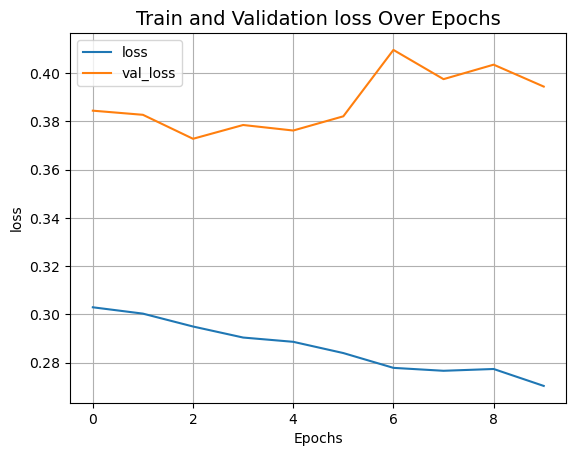

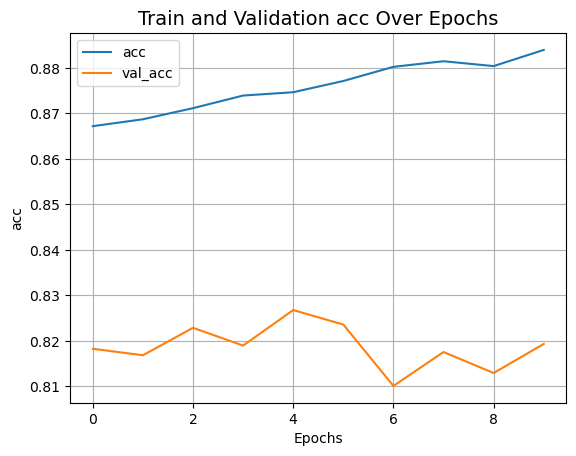

In [91]:
import matplotlib.pyplot as plt
model.compile(optimizer='adam',
loss='binary_crossentropy',
metrics=['acc'])
history = model.fit(x_sent_train, y_sent_train,
epochs = 10,
batch_size = 512,
validation_data=(x_sent_val, y_sent_val))
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()
plot_result('loss')
plot_result('acc')

### Evalución del modelo

In [92]:
model.evaluate(x_sent_test, y_sent_test)

90/90 [==============================] - 1s 5ms/step - loss: 0.3962 - acc: 0.8285


[0.3961755931377411, 0.8284812569618225]

## Entrenamiento del modelo con transfer learning

In [93]:
model = Sequential()
model.add(layers.Embedding(max_features, 300, input_length=max_len))
model.add(layers.Conv1D(32, 3, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(16))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [94]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

Epoch 1/10
220/220 [==============================] - 24s 108ms/step - loss: 0.5566 - acc: 0.7039 - val_loss: 0.4139 - val_acc: 0.7984
Epoch 2/10
220/220 [==============================] - 25s 114ms/step - loss: 0.3914 - acc: 0.8225 - val_loss: 0.4192 - val_acc: 0.7920
Epoch 3/10
220/220 [==============================] - 24s 111ms/step - loss: 0.3724 - acc: 0.8314 - val_loss: 0.3751 - val_acc: 0.8179
Epoch 4/10
220/220 [==============================] - 24s 110ms/step - loss: 0.3492 - acc: 0.8444 - val_loss: 0.3742 - val_acc: 0.8172
Epoch 5/10
220/220 [==============================] - 24s 111ms/step - loss: 0.3404 - acc: 0.8474 - val_loss: 0.3738 - val_acc: 0.8214
Epoch 6/10
220/220 [==============================] - 25s 112ms/step - loss: 0.3352 - acc: 0.8513 - val_loss: 0.3911 - val_acc: 0.8147
Epoch 7/10
220/220 [==============================] - 27s 121ms/step - loss: 0.3302 - acc: 0.8521 - val_loss: 0.3750 - val_acc: 0.8204
Epoch 8/10
220/220 [==============================] - 2

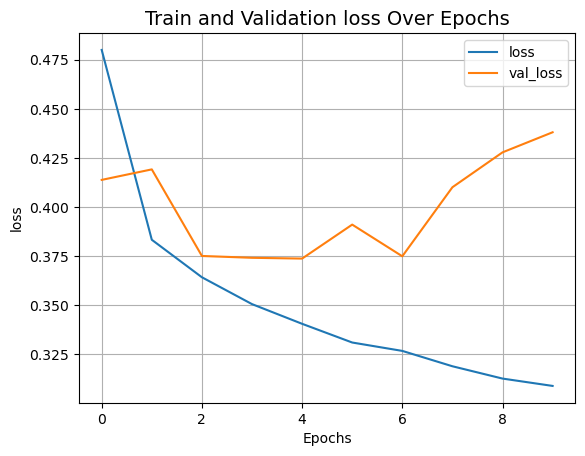

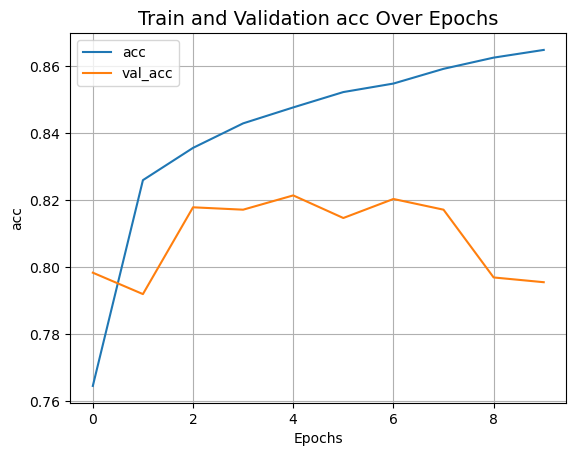

In [95]:
model.compile(optimizer='adam',
loss='binary_crossentropy',
metrics=['acc'])
history = model.fit(x_sent_train, y_sent_train,
epochs = 10,
batch_size = 512,
validation_data=(x_sent_val, y_sent_val))
plot_result('loss')
plot_result('acc')

### Evaluación del modelo

In [96]:
model.evaluate(x_sent_test, y_sent_test)

90/90 [==============================] - 0s 5ms/step - loss: 0.4282 - acc: 0.7976


[0.42824453115463257, 0.7976148724555969]

A partir de los modelos, podemos observar que al utilizar transfer learning nuevamente la presición del modelo es más baja.

## Clasificación de producto

### Tokenización

In [97]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(tr_review+val_review+te_review)
sequences = tokenizer.texts_to_sequences(tr_review+val_review+te_review)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 44003 unique tokens.


### Pad sequence

In [98]:
tam_val = len(val_review)
tam_te = len(te_review)
data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(tr_product + val_product + te_product)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
x_prod_train = data[:training_samples]
y_prod_train = labels[:training_samples]
x_prod_val = data[training_samples: training_samples+ tam_val]
y_prod_val = labels[training_samples: training_samples+ tam_val]
x_prod_test = data[training_samples + tam_val: training_samples+tam_val+tam_te]
y_prod_test = labels[training_samples + tam_val: training_samples+tam_val+tam_te]

Shape of data tensor: (117807, 100)
Shape of label tensor: (117807,)


### Arquitectura del modelo

Para la clasificación del tipo de producto utilizamos la misma arquitectura que para análisis de sentimiento, sin embargo, dado que la clasificación es de 7 categorías utilizamos softmax.

In [99]:
model = Sequential()
model.add(layers.Embedding(max_features, 300, input_length=max_len))
model.add(layers.Conv1D(32, 3, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(16))
model.add(layers.Dense(7, activation = 'softmax'))

### Entrenamiento del modelo sin transfer learning

Epoch 1/10
220/220 [==============================] - 30s 136ms/step - loss: 1.7372 - acc: 0.3357 - val_loss: 1.3754 - val_acc: 0.4998
Epoch 2/10
220/220 [==============================] - 29s 133ms/step - loss: 1.2773 - acc: 0.5372 - val_loss: 1.3274 - val_acc: 0.5158
Epoch 3/10
220/220 [==============================] - 30s 137ms/step - loss: 1.1339 - acc: 0.5929 - val_loss: 1.3528 - val_acc: 0.5091
Epoch 4/10
220/220 [==============================] - 29s 134ms/step - loss: 1.0129 - acc: 0.6394 - val_loss: 1.4167 - val_acc: 0.4941
Epoch 5/10
220/220 [==============================] - 30s 136ms/step - loss: 0.8975 - acc: 0.6858 - val_loss: 1.5241 - val_acc: 0.4842
Epoch 6/10
220/220 [==============================] - 30s 136ms/step - loss: 0.7886 - acc: 0.7290 - val_loss: 1.6438 - val_acc: 0.4803
Epoch 7/10
220/220 [==============================] - 30s 137ms/step - loss: 0.6837 - acc: 0.7704 - val_loss: 1.7950 - val_acc: 0.4657
Epoch 8/10
220/220 [==============================] - 3

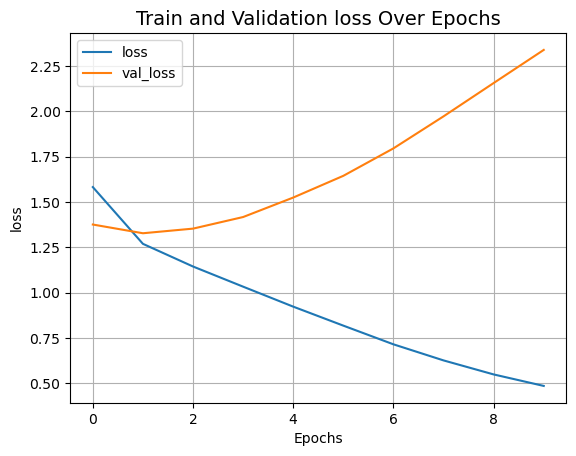

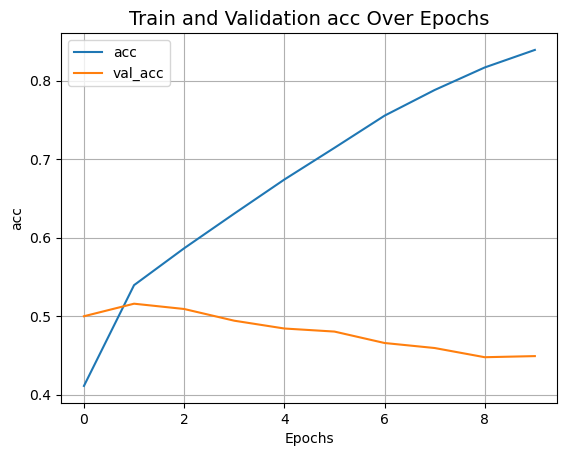

In [100]:
model.compile(optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['acc'])
history = model.fit(x_prod_train, y_prod_train,
epochs = 10,
batch_size = 512,
validation_data=(x_prod_val, y_prod_val))
plot_result('loss')
plot_result('acc')

### Evaluación del modelo

In [101]:
model.evaluate(x_prod_test, y_prod_test)

90/90 [==============================] - 1s 5ms/step - loss: 2.4216 - acc: 0.4402


[2.4215919971466064, 0.4401964247226715]

### Entrenamiento del modelo con transfer learnig

In [103]:
model = Sequential()
model.add(layers.Embedding(max_features, 300, input_length=max_len))
model.add(layers.Conv1D(32, 3, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(16))
model.add(layers.Dense(7, activation = 'softmax'))

In [104]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

Epoch 1/10
220/220 [==============================] - 26s 115ms/step - loss: 1.7853 - acc: 0.3164 - val_loss: 1.5196 - val_acc: 0.4359
Epoch 2/10
220/220 [==============================] - 24s 109ms/step - loss: 1.4761 - acc: 0.4472 - val_loss: 1.4342 - val_acc: 0.4707
Epoch 3/10
220/220 [==============================] - 24s 109ms/step - loss: 1.4026 - acc: 0.4826 - val_loss: 1.4125 - val_acc: 0.4881
Epoch 4/10
220/220 [==============================] - 26s 117ms/step - loss: 1.3766 - acc: 0.4930 - val_loss: 1.3946 - val_acc: 0.4924
Epoch 5/10
220/220 [==============================] - 24s 111ms/step - loss: 1.3442 - acc: 0.5067 - val_loss: 1.3895 - val_acc: 0.4963
Epoch 6/10
220/220 [==============================] - 24s 109ms/step - loss: 1.3356 - acc: 0.5097 - val_loss: 1.3702 - val_acc: 0.4934
Epoch 7/10
220/220 [==============================] - 23s 106ms/step - loss: 1.3138 - acc: 0.5173 - val_loss: 1.3944 - val_acc: 0.4959
Epoch 8/10
220/220 [==============================] - 2

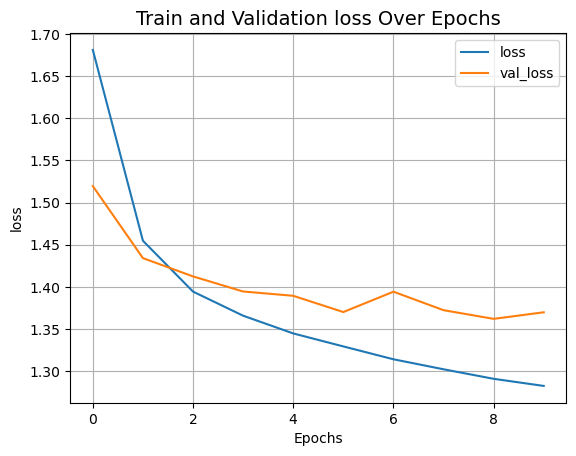

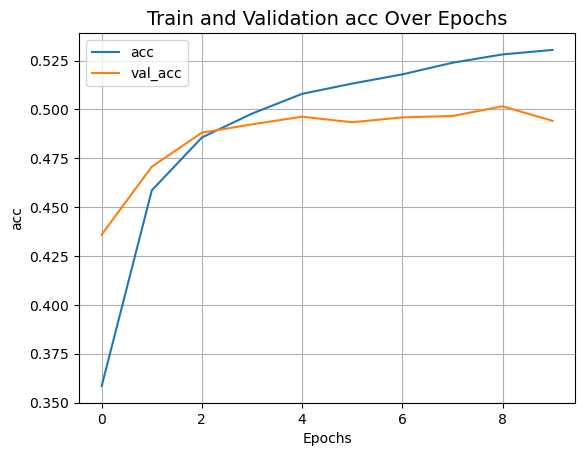

In [105]:
model.compile(optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['acc'])
history = model.fit(x_prod_train, y_prod_train,
epochs = 10,
batch_size = 512,
validation_data=(x_prod_val, y_prod_val))
plot_result('loss')
plot_result('acc')

### Evaluación del modelo

In [106]:
model.evaluate(x_prod_test, y_prod_test)

90/90 [==============================] - 0s 5ms/step - loss: 1.4164 - acc: 0.4819


[1.4164330959320068, 0.48193615674972534]

Nuevamente no hay diferencias significativas al utilizar los embeddings preentrenados. Por lo que es importante revisar porque se da este comportamiento, hacer una preprocesamiento de los datos podría modificar este comportamiento.